- build application
- test it manually
- use ragas to calculate a score
- make an improvement
- recompute score

In [1]:
import nest_asyncio

nest_asyncio.apply()

In [2]:
from llama_index import VectorStoreIndex, SimpleDirectoryReader, ServiceContext,OpenAIEmbedding
from langchain.embeddings import HuggingFaceEmbeddings

import pandas as pd

def build_query_engine(embed_model):
    vector_index = VectorStoreIndex.from_documents(
        documents, service_context=ServiceContext.from_defaults(chunk_size=512),
        embed_model=embed_model,
    )
    
    
    query_engine = vector_index.as_query_engine(similarity_top_k=2)
    return query_engine

# Build an LLM Application

In [36]:
from llama_index import download_loader

SemanticScholarReader = download_loader("SemanticScholarReader")
loader = SemanticScholarReader()
phrases = ["embeddings", "large language models","BERT", "sentiment classification"]
documents = [loader.load_data(query=i, limit=100) for i in phrases]
documents = sum(documents, [])

In [37]:
len(documents)

400

In [38]:
openai_model = OpenAIEmbedding()
vector_index = VectorStoreIndex.from_documents(
    documents, 
    service_context=ServiceContext.from_defaults(chunk_size=512),
    embed_model=openai_model,
)
vector_index.storage_context.persist("openai")

# Test it Manually

In [ ]:
!llamachat openai

# Test with Ragas

1. Build a test dataset
2. Evaluate with Ragas Metrics

In [5]:
from ragas.testset import TestsetGenerator

testsetgenerator = TestsetGenerator.from_default()
test_size = 50  # Number of samples to generate
testset = testsetgenerator.generate(documents, test_size=test_size)

/opt/anaconda3/envs/ragas/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
171it [04:21,  1.32it/s]                                                                

error occured in eval Please provide the context to be evaluated.


1275it [12:22,  1.72it/s]


In [1]:
eval('2.')

2.0

In [8]:
test_df = testset.to_pandas()
test_df.head()

,question,context,answer,question_type,episode_done
0,How accurate is Chinchilla on the MMLU benchmark?,- We test this hypothesis by training a predic...,Chinchilla is more accurate than Gopher on the...,conditional,False
1,"In comparison, how does Gopher perform on the ...",Chinchilla uniformly and significantly outperf...,"In comparison, Gopher performs worse than Chin...",conditional,True
2,What impact does interacting with an unreliabl...,"- On these tasks, we find that human participa...",Interacting with an unreliable large-language-...,conditional,True
3,What is the name of the resulting model after ...,We call the resulting model WizardLM.\nOur fin...,The name of the resulting model after fine-tun...,simple,True
4,What is the impact of the Selection-Inference ...,"- ""We show that language models tend to perfor...",The impact of the Selection-Inference framewor...,reasoning,True


In [9]:
test_df.question_type.value_counts()

question_type
conditional    22
reasoning      22
simple         17
Name: count, dtype: int64

In [10]:
test_df.to_csv("semantic_testdata.csv")

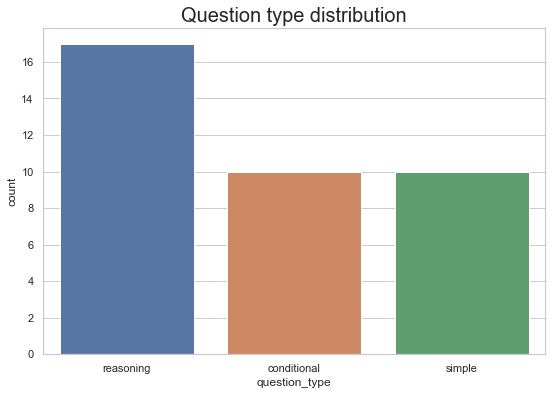

In [39]:
# evaluate with ragas
from ragas.llama_index import evaluate
from ragas.metrics import (
    context_precision,
    context_recall,
)
from ragas.llama_index import evaluate

metrics = [
    context_precision,
    context_recall,
]

test_questions = test_df['question'].values.tolist()
test_answers = [[item] for item in test_df['answer'].values.tolist()]
qe1 = build_query_engine(openai_model)
result = evaluate(qe1, metrics, test_questions, test_answers)

evaluating with [context_precision]


100%|█████████████████████████████████████████████████████| 5/5 [03:16<00:00, 39.28s/it]


evaluating with [context_recall]


100%|█████████████████████████████████████████████████████| 5/5 [04:52<00:00, 58.57s/it]


In [40]:
openai_result = result
openai_result

{'ragas_score': 0.3606, 'context_precision': 0.2652, 'context_recall': 0.5634}

In [41]:
openai_result_df = openai_result.to_pandas()
openai_result_df.head()

,question,contexts,answer,ground_truths,context_precision,context_recall
0,How accurate is Chinchilla on the MMLU benchmark?,[This also means that Chinchilla uses substant...,Chinchilla achieves a state-of-the-art average...,[Chinchilla is more accurate than Gopher on th...,0.090909,0.0
1,"In comparison, how does Gopher perform on the ...",[This also means that Chinchilla uses substant...,Gopher's performance on the MMLU benchmark is ...,"[In comparison, Gopher performs worse than Chi...",0.333333,1.0
2,What impact does interacting with an unreliabl...,"[On these tasks, we find that human participan...",Interacting with an unreliable large-language-...,[Interacting with an unreliable large-language...,0.000000,0.5
3,What is the name of the resulting model after ...,[Training language models to follow instructio...,The resulting model after fine-tuning with AI-...,[The name of the resulting model after fine-tu...,0.200000,0.0
4,What is the impact of the Selection-Inference ...,[Selection-Inference: Exploiting Large Languag...,The Selection-Inference (SI) framework has a p...,[The impact of the Selection-Inference framewo...,0.428571,0.0


# Make Improvements

In [42]:
flag_model = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")
query_engine2 = build_query_engine(flag_model)
result = evaluate(query_engine2, metrics, test_questions, test_answers)

evaluating with [context_precision]


100%|█████████████████████████████████████████████████████| 5/5 [03:16<00:00, 39.28s/it]


evaluating with [context_recall]


100%|█████████████████████████████████████████████████████| 5/5 [04:56<00:00, 59.29s/it]


In [43]:
hf_result = result
hf_result

{'ragas_score': 0.3560, 'context_precision': 0.2597, 'context_recall': 0.5655}

In [46]:
hf_result_df = hf_result.to_pandas()
hf_result_df.head()

,question,contexts,answer,ground_truths,context_precision,context_recall
0,How accurate is Chinchilla on the MMLU benchmark?,[This also means that Chinchilla uses substant...,Chinchilla achieves a state-of-the-art average...,[Chinchilla is more accurate than Gopher on th...,0.090909,0.0
1,"In comparison, how does Gopher perform on the ...",[This also means that Chinchilla uses substant...,Gopher's performance on the MMLU benchmark is ...,"[In comparison, Gopher performs worse than Chi...",0.333333,1.0
2,What impact does interacting with an unreliabl...,"[On these tasks, we find that human participan...",Interacting with an unreliable large-language-...,[Interacting with an unreliable large-language...,0.000000,0.5
3,What is the name of the resulting model after ...,[Training language models to follow instructio...,The resulting model after fine-tuning with AI-...,[The name of the resulting model after fine-tu...,0.200000,0.0
4,What is the impact of the Selection-Inference ...,[Selection-Inference: Exploiting Large Languag...,The Selection-Inference (SI) framework has a p...,[The impact of the Selection-Inference framewo...,0.428571,0.0


In [58]:
hf_result_df.to_csv("test_to_debug.csv",index=False)

In [53]:
hf_result_df.iloc[4]['answer']

'The Selection-Inference (SI) framework has a positive impact on the performance of large language models (LLMs) in multi-step logical reasoning problems. It improves the performance of LLMs by over 100% compared to an equivalent vanilla baseline on a suite of 10 logical reasoning tasks. Additionally, the SI framework even outperforms a significantly larger baseline model on the same suite of tasks. The SI framework utilizes pre-trained LLMs as general processing modules and alternates between selection and inference to generate a series of interpretable, causal reasoning steps leading to the final answer. This approach allows LLMs to chain together multiple reasoning steps and solve more complex problems effectively.'

In [52]:
hf_result_df.iloc[4]['contexts']

array(['Selection-Inference: Exploiting Large Language Models for Interpretable Logical Reasoning Large language models (LLMs) have been shown to be capable of impressive few-shot generalisation to new tasks. However, they still tend to perform poorly on multi-step logical reasoning problems. Here we carry out a comprehensive evaluation of LLMs on 50 tasks that probe different aspects of logical reasoning. We show that language models tend to perform fairly well at single step inference or entailment tasks, but struggle to chain together multiple reasoning steps to solve more complex problems. In light of this, we propose a Selection-Inference (SI) framework that exploits pre-trained LLMs as general processing modules, and alternates between selection and inference to generate a series of interpretable, casual reasoning steps leading to the final answer. We show that a 7B parameter LLM used within the SI framework in a 5-shot generalisation setting, with no fine-tuning, yields a perfor

In [48]:
hf_result_df[(openai_result_df["context_recall"] - hf_result_df["context_recall"]) > 0]

,question,contexts,answer,ground_truths,context_precision,context_recall
50,How does the LLM-Augmenter system incorporate ...,[Check Your Facts and Try Again: Improving Lar...,The LLM-Augmenter system incorporates external...,[The LLM-Augmenter system incorporates externa...,0.266667,0.571429


In [29]:
openai_result_df.iloc[15]

question             In what ways does the calibration framework im...
contexts             [Assistance with large language models A core ...
answer               The calibration framework improves alignment w...
ground_truths        [The calibration framework improves alignment ...
context_precision                                                  0.1
context_recall                                                0.571429
Name: 49, dtype: object

In [26]:
openai_result_df.iloc[49]['question']

'In what ways does the calibration framework improve alignment with human judgments?'

In [31]:
openai_result_df.iloc[49]['ground_truths']

array(['The calibration framework improves alignment with human judgments by implementing three strategies: Multiple Evidence Calibration, Balanced Position Calibration, and Human-in-the-Loop Calibration. These strategies ensure that the evaluator model generates multiple evaluation evidence, aggregates results across various orders, and measures the difficulty of each example. Additionally, the framework includes manual annotation of "win/tie/lose" outcomes from ChatGPT and Vicuna-13B, which helps mitigate evaluation bias and achieve closer alignment with human judgments.'],
      dtype=object)

In [27]:
openai_result_df.iloc[49]['answer']

'The calibration framework improves alignment with human judgments by implementing three strategies. First, the Multiple Evidence Calibration strategy requires the evaluator model to generate multiple evaluation evidence before assigning ratings. This helps to ensure a more comprehensive and accurate assessment of the candidate responses. Second, the Balanced Position Calibration strategy aggregates results across various orders to determine the final score. By considering different orders of appearance in the context, the evaluation becomes less susceptible to manipulation and provides a more balanced and fair assessment. Finally, the Human-in-the-Loop Calibration strategy introduces a balanced position diversity entropy to measure the difficulty of each example and seeks human assistance when needed. This strategy allows for human intervention in cases where the evaluator model may struggle to accurately evaluate certain responses. Overall, these strategies work together to mitigate 

In [28]:
hf_result_df.iloc[49]['answer']

'The calibration framework improves alignment with human judgments by implementing three strategies. First, the Multiple Evidence Calibration strategy requires the evaluator model to generate multiple evaluation evidence before assigning ratings. This helps to gather more information and reduce bias in the evaluation process. Second, the Balanced Position Calibration strategy aggregates results across various orders to determine the final score. By considering different orders of appearance in the context, the evaluation becomes more balanced and less susceptible to manipulation. Finally, the Human-in-the-Loop Calibration strategy introduces a balanced position diversity entropy to measure the difficulty of each example and seeks human assistance when needed. This ensures that human judgment is taken into account and helps to address challenging cases where the evaluator model may struggle. Overall, these strategies work together to mitigate evaluation bias and bring the evaluation pro